In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns
import scipy
import scipy.stats

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.9.1


In [3]:
import Training

In [4]:
N_CPUS = 4

In [5]:
tf.config.set_logical_device_configuration(
    tf.config.list_physical_devices('CPU')[0],
    [tf.config.LogicalDeviceConfiguration() for n in range(N_CPUS)]
)

## Load Data

In [6]:
featFileName = "../Data/features_combined.csv"
batch_pd = pd.read_csv(featFileName, index_col=False)

In [7]:
bat_info = batch_pd.loc[:,'policy':'cycle_life']
bat_info

,policy,barcode,cycle_life
0,3_6C-80PER_3_6C,???,1189
1,3_6C-80PER_3_6C,???,1178
2,3_6C-80PER_3_6C,???,1176
3,4C-80PER_4C,???,1225
4,4C-80PER_4C,???,1226
...,...,...,...
75,6C_31PER_4_25C,???,462
76,6C_40PER_4C,???,457
77,6C_4PER_4_75C,???,487
78,6C_52PER_3_5C,???,429


In [8]:
feat = batch_pd.drop(['policy','barcode','cycle_life','QDiffLinVar'], axis=1).to_numpy()
feat

array([[ 1.071,  0.468,  1.076, ...,  1.091,  0.   ,  1.072],
       [ 1.075,  0.009,  1.081, ...,  1.081, -0.   ,  1.085],
       [ 1.08 ,  0.008,  1.085, ...,  1.085, -0.   ,  1.089],
       ...,
       [ 1.07 ,  0.005,  1.073, ...,  1.075, -0.   ,  1.081],
       [ 1.073,  0.007,  1.08 , ...,  1.078, -0.   ,  1.081],
       [ 1.042,  0.008,  1.047, ...,  1.049, -0.   ,  1.055]])

In [9]:
# quoted: "data fix"
feat[0,9] = 1.692e-5;
feat[0,10] = 1.0750;

feat[14,1] = 0.00397;
feat[14,9] = -4.8296e-5;
feat[14,10] = 1.0705;

### Data Split
fast-normal charging split and then train-test split

In [10]:
fast_charge_indices = bat_info['policy'].str.match("^[5-8].*C")
slow_charge_feat = feat[~fast_charge_indices]
slow_charge_label = bat_info["cycle_life"][~fast_charge_indices]
fast_charge_feat = feat[fast_charge_indices]
fast_charge_label = bat_info["cycle_life"][fast_charge_indices]

In [11]:
feat_train = slow_charge_feat[0::2]
feat_test = slow_charge_feat[1::2]
label_train = slow_charge_label[0::2]
label_test = slow_charge_label[1::2]

In [12]:
# scale data
feat_train_scaled = scipy.stats.zscore(feat_train)
feat_test_scaled = scipy.stats.zmap(feat_test, feat_train)

## Load Model
Load the 'base' model trained on 'fast charging' data subset.

In [13]:
def load_base_model():
    model = keras.models.load_model('../discharge_model/saved_model/DischargeModelFastTF')
    return model

In [14]:
discharge_model_fast = load_base_model()
discharge_model_fast.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 14        
                                                                 
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


## Model Building

### Transfer Learning (Layering Method)

In [15]:
def make_layered_transfer_model():
    base_model = load_base_model()
    base_model.trainable = False

    transfer_model = keras.models.Sequential([
        layers.Dense(units=13,
            kernel_initializer=keras.initializers.Identity()),
        base_model
    ])
    
    # Initialize layer shape to match training batch size
    transfer_model(feat_train_scaled)

    transfer_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error')
    
    # copy and freeze weights for single-node layer
    # transfer_model.layers[1].set_weights(
    #     discharge_model_fast.layers[0].get_weights()
    # )
    # transfer_model.layers[1].trainable = False
    
    return transfer_model

In [16]:
make_layered_transfer_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (15, 13)                  182       
                                                                 
 sequential (Sequential)     (None, 1)                 14        
                                                                 
Total params: 196
Trainable params: 182
Non-trainable params: 14
_________________________________________________________________


### Transfer Learning (fine tuning only)

In [17]:
def make_finetuned_transfer_model():
    # transfer_model = keras.models.Sequential([
    #     layers.Dense(units=1)
    # ])
    transfer_model = load_base_model()
    
    # Initialize layer shape to match training batch size
    # transfer_model(feat_train_scaled)

    # transfer_model.compile(
    #     optimizer=keras.optimizers.Adam(learning_rate=0.001),
    #     loss='mean_squared_error')
    
    # transfer_model.set_weights(discharge_model_fast.get_weights())

    return transfer_model

In [18]:
make_finetuned_transfer_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 14        
                                                                 
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


## Train Models

In [19]:
cpus = [device.name for device in tf.config.list_logical_devices()]

### Layered Transfer Models

In [20]:
results1 = Training.multithread_train(
    feat_train_scaled,
    label_train,
    feat_test_scaled,
    label_test,
    make_layered_transfer_model,
    device_list=np.resize(cpus, 10),
    epochs=50,
    num_threads=len(cpus)
)

Training on /device:CPU:0
Training on /device:CPU:1
Training on /device:CPU:2
Training on /device:CPU:3
Training on /device:CPU:0
Training on /device:CPU:1
Training on /device:CPU:2
Training on /device:CPU:3
Training on /device:CPU:0
Training on /device:CPU:1


### Fine-Tuned Transfer Models

In [21]:
results2 = Training.multithread_train(
    feat_train_scaled,
    label_train,
    feat_test_scaled,
    label_test,
    make_finetuned_transfer_model,
    device_list=np.resize(cpus, 10),
    epochs=1000,
    num_threads=len(cpus)
)

Training on /device:CPU:0
Training on /device:CPU:1
Training on /device:CPU:2
Training on /device:CPU:3
Training on /device:CPU:0
Training on /device:CPU:1
Training on /device:CPU:2
Training on /device:CPU:3
Training on /device:CPU:0
Training on /device:CPU:1


## Evaluate Models

In [22]:
layered_RMSE = pd.DataFrame(results1)
finetuned_RMSE = pd.DataFrame(results2)

In [23]:
all_RMSE = pd.concat([layered_RMSE['RMSE'], finetuned_RMSE['RMSE']], axis=1, keys=['Layered','Fine Tuned'])
all_RMSE

,Layered,Fine Tuned
0,138.527087,141.691828
1,138.527087,141.691828
2,138.527087,141.691828
3,138.527087,141.691828
4,138.527080,141.691828
5,138.527087,141.691828
6,138.527087,141.691828
7,138.527087,141.691828
8,138.527087,141.691828
9,138.527087,141.691828


In [24]:
RMSE_stats = all_RMSE.describe().transpose().drop(['25%', '50%', '75%'], axis=1)
RMSE_stats

,count,mean,std,min,max
Layered,10.0,138.527087,0.000002,138.527080,138.527087
Fine Tuned,10.0,141.691828,0.000000,141.691828,141.691828


In [25]:
def plot_loss(history, ylims = [50, 300], ax_names={'loss': 'loss', 'val_loss': 'val_loss'}):
    plt.plot(np.sqrt(history.history['loss']), label=ax_names['loss'])
    plt.plot(np.sqrt(history.history['val_loss']), label=ax_names['val_loss'])
    plt.ylim(ylims)
    plt.xlabel('Epoch')
    plt.ylabel('Error [cycles]')
    plt.legend()
    plt.grid(True)
    # plt.show()

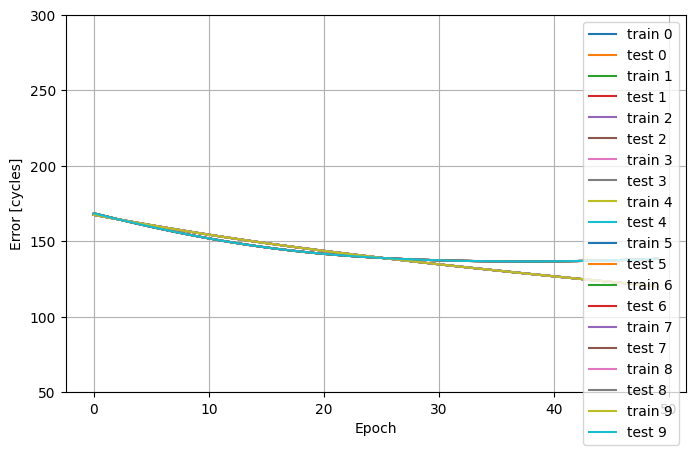

In [26]:
plt.figure('LayeredLoss', figsize=(8,5), dpi=100, facecolor='w', edgecolor='k')
for i in range(len(layered_RMSE)):
    plot_loss(layered_RMSE['history'][i],
        ax_names={
            'loss': 'train '+str(i),
            'val_loss': 'test '+str(i)
        })
plt.show()

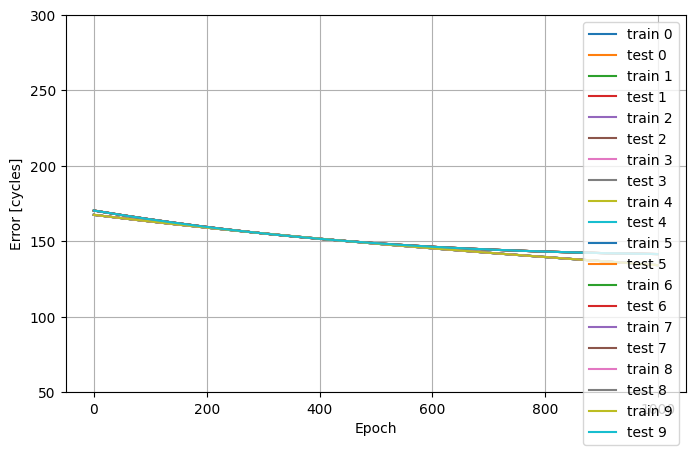

In [27]:
plt.figure('FineTunedLoss', figsize=(8,5), dpi=100, facecolor='w', edgecolor='k')
for i in range(len(finetuned_RMSE)):
    plot_loss(finetuned_RMSE['history'][i],
        ax_names={
            'loss': 'train '+str(i),
            'val_loss': 'test '+str(i)
        })
plt.show()

In [28]:
import pathlib
results_folder = pathlib.Path('./results')
results_folder.mkdir(exist_ok=True)

In [29]:
all_RMSE.to_csv('./results/runs.csv')
RMSE_stats.to_csv('./results/statistics.csv')